# Training Latent Graph Autoencoder

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import torchvision
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Scale
from torch.utils.data.dataloader import DataLoader
from torch.nn.functional import one_hot
from graph_autoencoder import LatentGraphVAE
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from datetime import datetime

In [3]:
device = 'cuda:1'

In [4]:
transforms = Compose([
    ToTensor(),
    Resize((320//2, 480//2)),
    ])
dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=1)

In [5]:
def overlap_penalty(layers):
    nlayers = layers.shape[0]
    idxs = torch.combinations(torch.arange(nlayers)).to(device)
    # TODO this 3 assumes that there are 3 channels. Need to make this a variable
    binned = torch.clamp(layers.sum(dim=1)/3, 0)
    overlap = torch.mean((binned[idxs[:,0]] * binned[idxs[:,1]]))
    return overlap

In [6]:
def to_np(tnsr):
    return tnsr.detach().cpu().numpy().transpose((1,2,0))

In [7]:
def l2_penalty(layers):
    return torch.mean(layers**2)

In [8]:
def l1_penalty(layers):
    return torch.mean(torch.abs(layers))

In [9]:
def leaky_clamp(t, a):
    # TODO figure out how to implement this
    pass

In [10]:
def variance(layers):
    midx = torch.argmax(layers.sum(dim=1), dim=0)
    oh = one_hot(midx, num_classes=8).permute((2,0,1))
    return (layers.sum(dim=1) * oh).mean(dim=(1,2)).var()


In [11]:
def build_image(layers):
    midx = torch.argmax(layers.sum(dim=1), dim=0)
    recon = torch.gather(layers, dim=0, index=midx.expand((1,3,-1,-1))).squeeze(0)
    # recon = layers.sum(dim=0)
    return recon

In [22]:
lgvae = LatentGraphVAE(n_channels=3, w=320//2, h=480//2, device=device).to(device)
optim = torch.optim.Adam(params=lgvae.parameters())

optim.zero_grad()
batch_size = 100
n_epochs = 5
i=0
batch_loss = 0
batch_variance = 0
batch_overlap = 0
batch_l1 = 0
batch_total = 0
checkpoint = 1000
niter = 100000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, niter//batch_size)

tmstp = datetime.strftime(datetime.now(), '%Y%m%d-%H%M')

image,_ = next(iter(dataloader))
# print(image.shape)

for epoch in range(n_epochs):
    i=0
    for image,_ in dataloader:
    # for j in range(niter):
        image = image.squeeze(0).to(device)
        nodes = lgvae(image)
        recon = build_image(nodes)
        # recon = nodes.sum(dim=0)
        overlap = overlap_penalty(nodes)
        variance_penalty = variance(nodes)
        recon_loss = torch.mean((recon - image)**2) 
        loss = recon_loss + overlap + variance_penalty
        loss.backward()
        batch_loss += float(recon_loss)/batch_size
        batch_overlap += float(overlap)/batch_size
        batch_total += float(loss)/batch_size
        batch_variance += float(variance_penalty)/batch_size
        
        i+=1
        if i%batch_size==0:
            optim.step()
            optim.zero_grad()
            lr = scheduler.get_last_lr()
            print(f"epoch={epoch:4d} n={i:8d} loss={batch_loss:8.4f} " +
                  f"overlap={batch_overlap:8.4f} variance={batch_variance:8.4f} " + 
                  f"lr={lr} total={batch_total}",
             flush=True)
            batch_loss = 0
            batch_overlap = 0
            batch_variance = 0
            batch_l1 = 0
            batch_total = 0
            # scheduler.step()
        if i%checkpoint==0:
            torch.save(lgvae.state_dict(), f'models/lgvae_{tmstp}.torch')
            n_nodes = nodes.shape[0]
            for node_idx in range(n_nodes):
                midx = torch.argmax(nodes.sum(dim=1), dim=0)
                oh = one_hot(midx, num_classes=n_nodes)
                node = nodes[node_idx]*oh[:,:,node_idx]
                save_image(nodes[node_idx], f'outputs/graph_ae_{epoch}-{i}-{node_idx}_{tmstp}.png')


epoch=   0 n=     100 loss=  0.2088 overlap=  0.0013 variance=  0.0003 lr=[0.001] total=0.21038139760494232
epoch=   0 n=     200 loss=  0.1893 overlap=  0.0010 variance=  0.0013 lr=[0.001] total=0.19158819511532785
epoch=   0 n=     300 loss=  0.1777 overlap=  0.0001 variance=  0.0003 lr=[0.001] total=0.17810227721929545
epoch=   0 n=     400 loss=  0.1622 overlap=  0.0007 variance=  0.0008 lr=[0.001] total=0.16371027946472172
epoch=   0 n=     500 loss=  0.1602 overlap=  0.0007 variance=  0.0007 lr=[0.001] total=0.16154811635613442
epoch=   0 n=     600 loss=  0.1534 overlap=  0.0005 variance=  0.0004 lr=[0.001] total=0.1542382156848908
epoch=   0 n=     700 loss=  0.1530 overlap=  0.0002 variance=  0.0001 lr=[0.001] total=0.15332435965538027
epoch=   0 n=     800 loss=  0.1455 overlap=  0.0005 variance=  0.0001 lr=[0.001] total=0.14611807599663737
epoch=   0 n=     900 loss=  0.1156 overlap=  0.0005 variance=  0.0003 lr=[0.001] total=0.11648263446986676
epoch=   0 n=    1000 loss=  

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


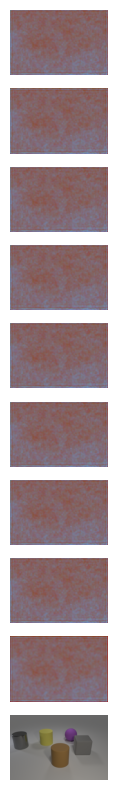

In [24]:
n_nodes = nodes.shape[0]
fig, axs = plt.subplots(n_nodes+2, figsize=(40,10))
nodes = lgvae(image)
for i in range(n_nodes):
    midx = torch.argmax(nodes.sum(dim=1), dim=0)
    oh = one_hot(midx, num_classes=n_nodes)
    node_np = to_np(nodes[i]*oh[:,:,i])
    # node_np = to_np(nodes[i])*8
    axs[i].axis('off')
    axs[i].imshow(node_np, interpolation='none')
axs[n_nodes].axis('off')
axs[n_nodes].imshow(to_np(recon))
axs[n_nodes+1].axis('off')
axs[n_nodes+1].imshow(to_np(image))

In [ ]:
nodes[:,2,:4,:4]

tensor([[[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
   

## Validation Set testing

In [ ]:
val_dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
iter_val_loader = iter(val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


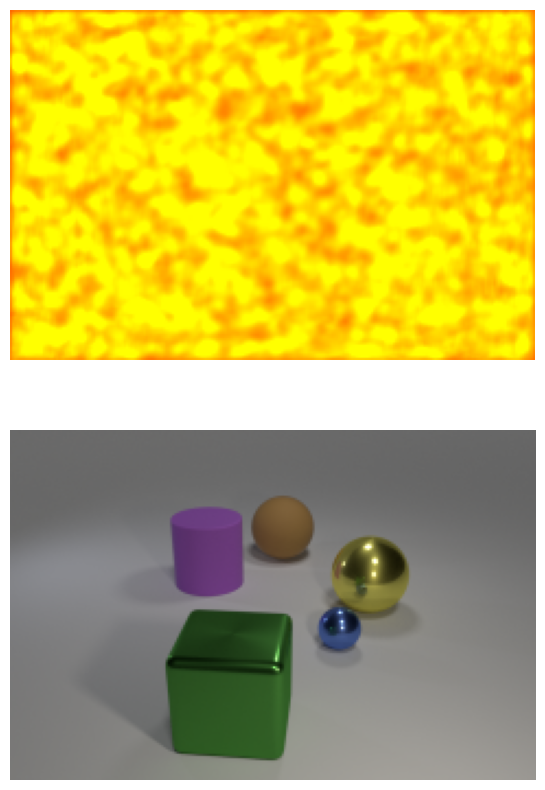

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

with torch.no_grad():
    val_recons = []
    for i in range(10):
        val_image,_ = next(iter_val_loader)
        val_image = val_image.squeeze(0).to(device)
        val_nodes = lgvae(val_image)
        val_recon = build_image(val_nodes)
        val_nprecon = to_np(val_recon)
        val_recons.append(val_recon)
    # print((val_recons[8] - vala_recons[2]).sum())
    axs[0].axis('off')
    axs[0].imshow(val_nprecon*8)
    axs[1].axis('off')
    axs[1].imshow(to_np(val_image))